In [4]:
!pip install accelerate

In [1]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, ToPILImage
from torchvision.io import read_image
from transformers import TrainingArguments, Trainer, AutoModel, AutoModelForImageClassification, AutoImageProcessor, DefaultDataCollator, ViTForImageClassification
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset

2024-04-15 18:15:43.570737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 18:15:43.570875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 18:15:43.676207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
torch.manual_seed(42)

In [3]:
model_checkpoint = "google/vit-base-patch16-224-in21k"
path_to_images = "/kaggle/input/gen-or-not/images/images"

In [4]:
dataset = load_dataset("imagefolder", data_dir="/kaggle/input/gen-or-not-distributed/image_ds")

Resolving data files:   0%|          | 0/1012 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
example = dataset["train"][0]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>,
 'label': 0}

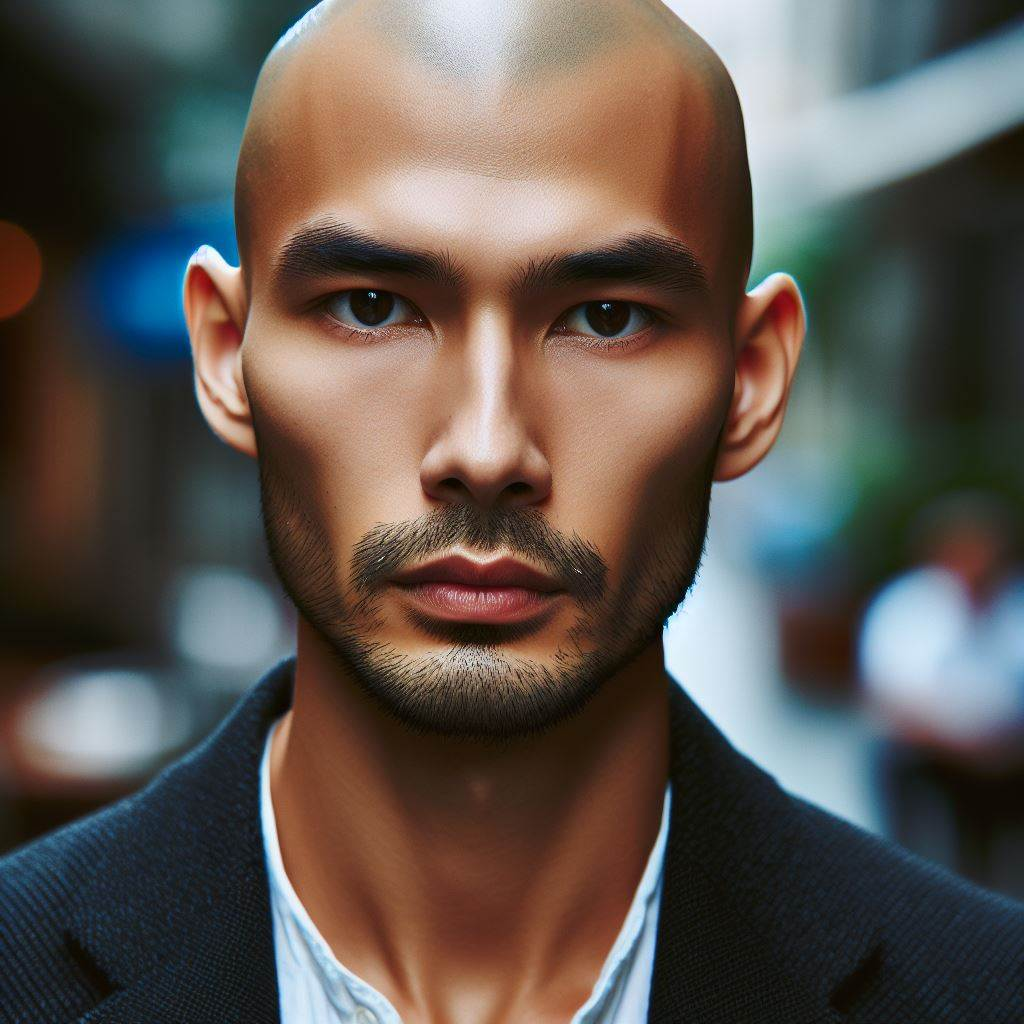

In [6]:
example['image']

In [85]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
id2label

{0: 'ai', 1: 'real'}

In [8]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['ai', 'real'], id=None)}

In [5]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [89]:
import albumentations as A

In [100]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


In [104]:
def preprocess(examples):
    examples["pixel_values"] = [transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
def preprocess1(examples):
    examples["pixel_values"] = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors='pt')['pixel_values']
    del examples["image"]
    return examples

In [97]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
test_ds = splits['test']

In [13]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 910
})

In [105]:
train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess1)


In [15]:
train_ds[0]

{'label': 1,
 'pixel_values': tensor([[[-0.9451, -0.9373, -0.9451,  ..., -0.9059, -0.8510, -0.8196],
          [-0.9451, -0.9529, -0.9216,  ..., -0.9059, -0.8745, -0.8588],
          [-0.9294, -0.9373, -0.9216,  ..., -0.9059, -0.8902, -0.8667],
          ...,
          [ 0.7804,  0.9216,  0.9373,  ..., -0.0431, -0.2078, -0.1373],
          [ 0.4510,  0.6157,  0.8196,  ...,  0.0431, -0.1451, -0.0745],
          [ 0.0510,  0.3961,  0.7176,  ...,  0.2157,  0.0118,  0.1059]],
 
         [[-0.9608, -0.9529, -0.9608,  ..., -0.9451, -0.9373, -0.9216],
          [-0.9686, -0.9529, -0.9373,  ..., -0.9373, -0.9451, -0.9373],
          [-0.9608, -0.9451, -0.9373,  ..., -0.9373, -0.9451, -0.9373],
          ...,
          [-0.2706, -0.1765, -0.1137,  ..., -0.8745, -0.9137, -0.8980],
          [-0.5294, -0.4196, -0.2314,  ..., -0.8824, -0.9451, -0.9059],
          [-0.7333, -0.5529, -0.2941,  ..., -0.8353, -0.9216, -0.8824]],
 
         [[-0.9529, -0.9451, -0.9529,  ..., -0.9529, -0.9216, -0.9059],

In [16]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 910
})

In [42]:
!pip install evaluate
import evaluate

accuracy = evaluate.load("accuracy")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00


In [43]:
data_collator = DefaultDataCollator()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [86]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
).to("cuda")
model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [106]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/aimage_model_vit",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.086400,0.204667,0.931373
1,0.060500,0.152703,0.941176
2,0.028900,0.094164,0.980392
4,0.017300,0.063106,0.980392
5,0.009500,0.052655,0.990196
6,0.012500,0.053349,0.990196
8,0.005300,0.055991,0.990196
9,0.007300,0.060868,0.990196


TrainOutput(global_step=140, training_loss=0.024642489531210492, metrics={'train_runtime': 297.5305, 'train_samples_per_second': 30.585, 'train_steps_per_second': 0.471, 'total_flos': 6.929333711336817e+17, 'train_loss': 0.024642489531210492, 'epoch': 9.82})

In [45]:
example = dataset["train"][5]['image']
encoding = image_processor(example.convert("RGB"), return_tensors="pt")
encoding = encoding.to('cuda')
encoding

{'pixel_values': tensor([[[[-0.8745, -0.8745, -0.8745,  ..., -0.8588, -0.8667, -0.8745],
          [-0.8588, -0.8588, -0.8588,  ..., -0.8588, -0.8667, -0.8745],
          [-0.8588, -0.8510, -0.8510,  ..., -0.8588, -0.8667, -0.8667],
          ...,
          [-0.8118, -0.8196, -0.8275,  ..., -0.4275, -0.4431, -0.4588],
          [-0.8196, -0.8275, -0.8353,  ..., -0.3725, -0.3725, -0.4039],
          [-0.8275, -0.8353, -0.8431,  ..., -0.3569, -0.3647, -0.3882]],

         [[-0.8824, -0.8824, -0.8824,  ..., -0.8667, -0.8745, -0.8824],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8667, -0.8745, -0.8824],
          [-0.8667, -0.8588, -0.8588,  ..., -0.8667, -0.8745, -0.8745],
          ...,
          [-0.8196, -0.8275, -0.8353,  ..., -0.3569, -0.3725, -0.3882],
          [-0.8275, -0.8353, -0.8431,  ..., -0.3020, -0.3020, -0.3333],
          [-0.8353, -0.8431, -0.8510,  ..., -0.2863, -0.2941, -0.3176]],

         [[-0.8431, -0.8431, -0.8431,  ..., -0.8275, -0.8353, -0.8431],
          [-0

In [46]:
model.eval()

outputs = model(pixel_values = encoding['pixel_values'])
logits = outputs.logits
logits

tensor([[ 1.0905, -1.0900]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: ai


In [55]:
sm = nn.Softmax(dim=1)
def probability_of_ai(pred):
    return sm(pred)[0][0].item()

In [32]:
probability_of_ai(logits)

0.8984806537628174

In [33]:
model.eval()
strikes = 0
count = 0
for obj in test_ds:
    label = obj['label']
    del obj['label']
    encoding = {'pixel_values':torch.unsqueeze(obj['pixel_values'], 0).to('cuda')}
    outputs = model(**encoding)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    if predicted_class == label:
        strikes += 1
    count += 1
print(strikes / count)

0.9803921568627451


In [107]:
controldata_path = "/kaggle/input/gen-or-not/test.csv"
control_df = pd.read_csv(controldata_path)
control_df

,id
0,Qt1fGUB0Vz.jpeg
1,j4Rhioq7R3.jpeg
2,rD0hgFHJUZ.jpeg
3,aY5z1EJsJ6.jpeg
4,qZ3IoxD2TE.jpeg
...,...
501,Qrme6EUmL1
502,4369Dl8wfs.jpeg
503,BrNEvRNpPu.jpeg
504,DuwXCNmeMx.webp


In [108]:
path_to_imgs = '/kaggle/input/gen-or-not/images/images/'
control_dict = {"id": [], "target": []}
for name in control_df["id"]:
    if "." in name:
       img_path = os.path.join(path_to_imgs, name)
    else:
        for image in os.listdir(path_to_imgs):
            if image.split('.')[0] == name:
                img_path = os.path.join(path_to_imgs, image)
                break
    pil_image = Image.open(img_path)
    encoding = image_processor(pil_image.convert("RGB"), return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
    control_dict["id"].append(name)
    control_dict["target"].append(probability_of_ai(logits))

In [109]:
final_df = pd.DataFrame.from_dict(control_dict)
final_df.to_csv('submit3.csv', index=False) 

VIT + DENSE

In [6]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_splits = splits['train'].train_test_split(test_size=0.5)
train1_ds = train_splits['train']
train2_ds = train_splits['test']
test_ds = splits['test']

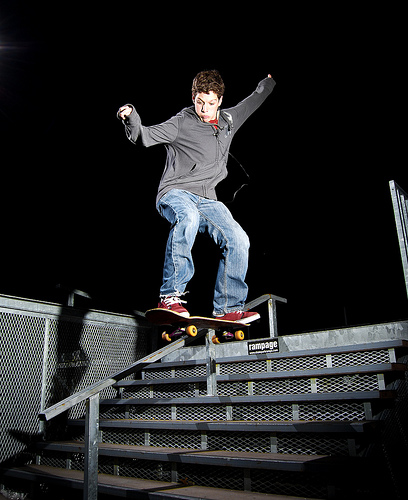

In [25]:
train1_ds[0]['image']

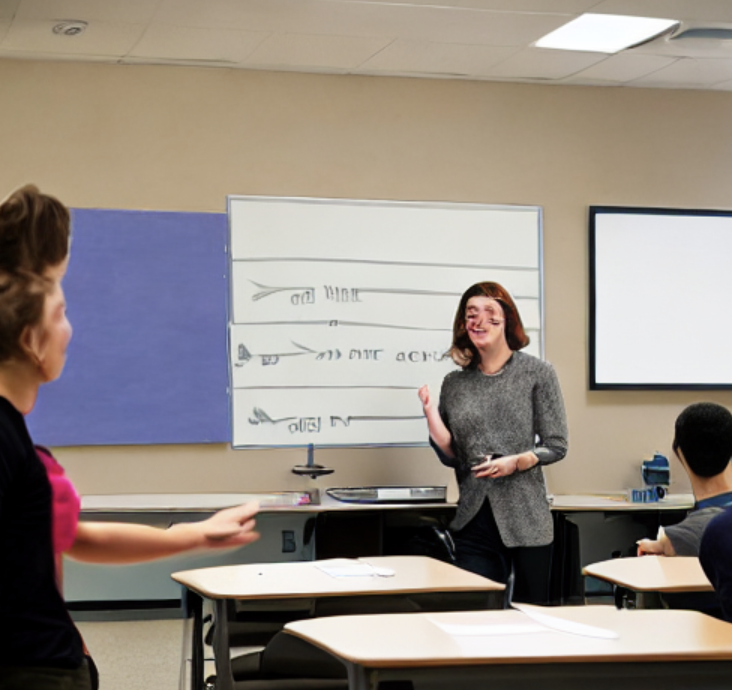

In [26]:
train2_ds[0]['image']

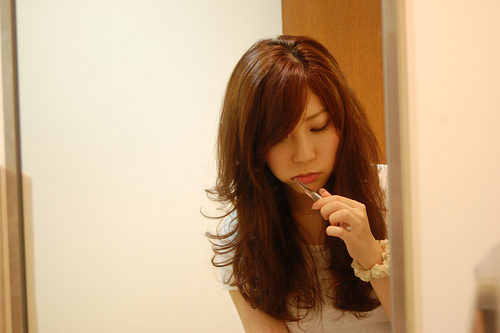

In [27]:
test_ds[0]['image']

In [32]:
def preprocess1(examples):
    examples["pixel_values"] = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors='pt')['pixel_values']
    del examples["image"]
    return examples

In [33]:
train1_ds.set_transform(preprocess1)
train2_ds.set_transform(preprocess1)
test_ds.set_transform(preprocess1)

In [34]:
train1_ds[0]

{'label': 1,
 'pixel_values': tensor([[[-0.9529, -0.9451, -0.9529,  ...,  0.4353,  0.4353,  0.4275],
          [-0.9373, -0.9294, -0.9686,  ...,  0.4353,  0.4353,  0.4275],
          [-0.9294, -0.9451, -0.9529,  ...,  0.4353,  0.4353,  0.4353],
          ...,
          [-0.0196, -0.0431, -0.0196,  ..., -0.1216, -0.0745, -0.1686],
          [ 0.1451,  0.0824,  0.1137,  ..., -0.0745, -0.0196,  0.0275],
          [ 0.0275, -0.2549, -0.4039,  ..., -0.1922, -0.0902,  0.0118]],
 
         [[-0.9137, -0.9059, -0.9137,  ...,  0.4353,  0.4353,  0.4275],
          [-0.8980, -0.8902, -0.9294,  ...,  0.4353,  0.4353,  0.4275],
          [-0.8902, -0.9059, -0.9137,  ...,  0.4353,  0.4353,  0.4275],
          ...,
          [ 0.0275, -0.0118, -0.0510,  ..., -0.0745, -0.0275, -0.1137],
          [ 0.1137,  0.0275,  0.0039,  ..., -0.0745, -0.0275,  0.0275],
          [ 0.0118, -0.2941, -0.4980,  ..., -0.2235, -0.1216, -0.0118]],
 
         [[-0.9686, -0.9608, -0.9686,  ...,  0.4510,  0.4510,  0.4431],

In [35]:
batch_size = 12 
train1_loader = DataLoader(train1_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [39]:
for x in train1_loader:
    print(x['pixel_values'].shape)
    break

torch.Size([12, 3, 224, 224])


In [11]:
vitmodel = ViTForImageClassification.from_pretrained(model_checkpoint, num_labels=512).to('cuda')
vitmodel

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [18]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x): # Called inside __call__ method
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = F.selu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.selu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [ ]:
image_processor(train1_ds)

In [37]:
from torch.optim import Adam

densemodel = DenseNet().cuda() # перемещаем на gpu, чтобы училось быстрее, жилось веселее
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3 
epochs = 10
optimizer = Adam(densemodel.parameters(), lr=learning_rate)

In [21]:
train1_ds[0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [45]:
vitmodel.eval()
x = vitmodel(pixel_values=torch.unsqueeze(train1_ds[0]['pixel_values'], 0).to('cuda'))
x.logits

tensor([[-0.0487,  0.0498,  0.0607,  0.0397, -0.1641,  0.0020, -0.0271, -0.1066,
          0.0666,  0.0449,  0.1081, -0.0169,  0.0800,  0.0827, -0.0028, -0.1148,
          0.0898, -0.1414, -0.0668, -0.0841,  0.0441,  0.0389, -0.0058,  0.0451,
          0.1185, -0.0819,  0.0367, -0.1170, -0.1298, -0.3367, -0.0228, -0.0236,
         -0.0069,  0.0642,  0.0081,  0.0594, -0.0633,  0.0157,  0.0962,  0.0319,
         -0.0305,  0.0266, -0.1037, -0.0793,  0.1582,  0.0988,  0.1177, -0.0379,
          0.0503,  0.1183, -0.0187,  0.0491, -0.1289, -0.0547, -0.0057,  0.0859,
         -0.0413,  0.0298, -0.1292,  0.1252,  0.1152,  0.0661, -0.1360,  0.1981,
         -0.1030, -0.1057, -0.0072,  0.0986, -0.0724, -0.0422, -0.0815, -0.0030,
         -0.0076, -0.0238,  0.1818, -0.0591, -0.0637, -0.0443,  0.0388,  0.1384,
          0.1320,  0.0399, -0.1599,  0.0935, -0.1887,  0.1104,  0.1257,  0.0247,
          0.1399,  0.0477, -0.1550,  0.0813, -0.0289, -0.1074, -0.0978,  0.0351,
          0.0314,  0.0164, -

In [51]:
y_pred = densemodel(x.logits)
y_pred

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([[0.4741, 0.5259]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [11]:
train1_ds_eval_emb = []
test_ds_eval_emb = []
for x in train1_ds:
    img = image_processor(x['image'].convert('RGB'), return_tensors="pt").to('cuda')
    train1_ds_eval_emb.append(vitmodel(pixel_values=img['pixel_values']))
for x in test_ds:
    img = image_processor(x['image'].convert('RGB'), return_tensors="pt").to('cuda')
    test_ds_eval_emb.append(vitmodel(pixel_values=img['pixel_values']))

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 40.12 MiB is free. Process 3114 has 15.85 GiB memory in use. Of the allocated memory 14.63 GiB is allocated by PyTorch, and 949.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [78]:
train1_ds_eval

ValueError: mean must have 4 elements if it is an iterable, got 3

In [58]:
for epoch in range(epochs): 
  densemodel.train()
  vitmodel.eval()
  train_samples_count = 0
  true_train_samples_count = 0 
  running_loss = 0

  for batch in train1_loader:
    x_data = vitmodel(pixel_values=batch['pixel_values'].cuda()) 
    y_data = batch['label'].cuda()

    y_pred = densemodel(x_data.logits)
    loss = criterion(y_pred, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    
    true_classified = (y_pred == y_data).sum().item() 
    true_train_samples_count += true_classified
    train_samples_count += len(x_data.logits) 
    

  train_accuracy = true_train_samples_count / train_samples_count
  print(f"[{epoch}] train loss: {running_loss}, accuracy: {round(train_accuracy, 4)}") 

  
  densemodel.eval()
  test_samples_count = 0
  true_test_samples_count = 0
  running_loss = 0

  for batch in test_loader:
    x_data = vitmodel(pixel_values=batch['pixel_values'].cuda()) 
    y_data = batch['label'].cuda()

    y_pred = densemodel(x_data.logits)
    loss = criterion(y_pred, y_data)

    loss.backward()

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    true_classified = (y_pred == y_data).sum().item()
    true_test_samples_count += true_classified
    test_samples_count += len(x_data.logits)

  test_accuracy = true_test_samples_count / test_samples_count
  print(f"[{epoch}] test loss: {running_loss}, accuracy: {round(test_accuracy, 4)}")

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


[0] train loss: 12.618390381336212, accuracy: 0.9824
[0] test loss: 3.6106468439102173, accuracy: 0.9216
[1] train loss: 12.94479125738144, accuracy: 0.9692
[1] test loss: 3.5598188042640686, accuracy: 0.9216
[2] train loss: 12.608081847429276, accuracy: 0.978
[2] test loss: 4.072993844747543, accuracy: 0.8627
[3] train loss: 12.826201379299164, accuracy: 0.9758
[3] test loss: 3.991799086332321, accuracy: 0.8922


KeyboardInterrupt: 

In [72]:
class AiDetectNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lvl1 = vitmodel
        self.lvl2 = densemodel
    def forward(self, pixel_values = None, labels = None): # Called inside __call__ method
        t = vitmodel(pixel_values=pixel_values.cuda())
        return densemodel(t.logits)

In [73]:
mymodel = AiDetectNet().cuda()

In [77]:
train2_loader = DataLoader(train2_ds, batch_size=batch_size)

In [78]:
for epoch in range(epochs): 
  mymodel.train()
  densemodel.train()
  vitmodel.train()
  train_samples_count = 0
  true_train_samples_count = 0 
  running_loss = 0

  for batch in train2_loader:
    x_data = batch['pixel_values'].cuda()
    y_data = batch['label'].cuda()

    y_pred = mymodel(pixel_values=x_data)
    loss = criterion(y_pred, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    
    true_classified = (y_pred == y_data).sum().item() 
    true_train_samples_count += true_classified
    train_samples_count += len(x_data) 
    

  train_accuracy = true_train_samples_count / train_samples_count
  print(f"[{epoch}] train loss: {running_loss}, accuracy: {round(train_accuracy, 4)}") 

  
  mymodel.eval()
  densemodel.eval()
  vitmodel.eval()
  test_samples_count = 0
  true_test_samples_count = 0
  running_loss = 0

  for batch in test_loader:
    x_data = batch['pixel_values'].cuda()
    y_data = batch['label'].cuda()

    y_pred = mymodel(pixel_values=x_data)
    loss = criterion(y_pred, y_data)

    loss.backward()

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    true_classified = (y_pred == y_data).sum().item()
    true_test_samples_count += true_classified
    test_samples_count += len(x_data)

  test_accuracy = true_test_samples_count / test_samples_count
  print(f"[{epoch}] test loss: {running_loss}, accuracy: {round(test_accuracy, 4)}")

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


[0] train loss: 16.072491139173508, accuracy: 0.8857
[0] test loss: 3.8107555508613586, accuracy: 0.8922
[1] train loss: 15.479417562484741, accuracy: 0.9033
[1] test loss: 4.221929460763931, accuracy: 0.8529
[2] train loss: 15.301649570465088, accuracy: 0.9077
[2] test loss: 3.667421370744705, accuracy: 0.9118
[3] train loss: 15.013504922389984, accuracy: 0.9187
[3] test loss: 3.882313758134842, accuracy: 0.8922
[4] train loss: 14.298705637454987, accuracy: 0.9363
[4] test loss: 3.435358613729477, accuracy: 0.9216
[5] train loss: 13.962196618318558, accuracy: 0.9451
[5] test loss: 3.7384428679943085, accuracy: 0.8922
[6] train loss: 13.6523617208004, accuracy: 0.956
[6] test loss: 3.53663432598114, accuracy: 0.9216
[7] train loss: 13.85464596748352, accuracy: 0.9473
[7] test loss: 3.7399711906909943, accuracy: 0.902
[8] train loss: 13.857772380113602, accuracy: 0.9473
[8] test loss: 3.772133320569992, accuracy: 0.902
[9] train loss: 13.96813553571701, accuracy: 0.9429
[9] test loss: 3

In [74]:
mymodel(pixel_values=torch.unsqueeze(train1_ds[0]['pixel_values'], 0).to('cuda'))

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


tensor([[1.0002e-18, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [79]:

path_to_imgs = '/kaggle/input/gen-or-not/images/images/'
control_dict = {"id": [], "target": []}
for name in control_df["id"]:
    mymodel.eval()
    densemodel.eval()
    vitmodel.eval()
    if "." in name:
       img_path = os.path.join(path_to_imgs, name)
    else:
        for image in os.listdir(path_to_imgs):
            if image.split('.')[0] == name:
                img_path = os.path.join(path_to_imgs, image)
                break
    pil_image = Image.open(img_path)
    encoding = image_processor(pil_image.convert("RGB"), return_tensors="pt").to('cuda')
    control_dict["id"].append(name)
    
    x = mymodel(**encoding)
    
    control_dict["target"].append(x[0][0].item())

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [80]:
final_df = pd.DataFrame.from_dict(control_dict)
final_df.to_csv('submit2.csv', index=False) 

In [75]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/aimage_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=7,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=mymodel,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train2_ds,
    eval_dataset=test_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipykernel_34/3198681762.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


RuntimeError: grad can be implicitly created only for scalar outputs